# Run

In [1]:
pip install country_converter pycountry

In [2]:
pip install pycountry-convert

In [3]:
!pip install category_encoders

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_curve
from xgboost import XGBClassifier, plot_importance
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pycountry_convert as pc
import seaborn as sns

In [5]:
booking_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone 3/data_hotel_booking_demand.csv")

In [6]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [7]:
booking_df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


In [8]:
booking_df.head(10)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
5,ESP,Direct,0,1,No Deposit,0,Transient-Party,A,0,1,0
6,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
7,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
8,UMI,Online TA,0,0,No Deposit,0,Transient,E,0,1,1
9,PRT,Groups,1,0,Non Refund,0,Contract,A,0,0,1


## Data cleaning


In [9]:
booking_df[booking_df['market_segment']=='Undefined']
# booking_df = booking_df[booking_df['market_segment'] != 'Undefined'].copy()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
70217,PRT,Undefined,0,0,No Deposit,0,Transient-Party,B,0,1,1


In [ ]:
booking_df.country.fillna('Unknown', inplace=True)

## Data transformation


In [10]:
replacements = {
    'CN': 'CHN', #Alpha-2 > Alpha-3 country code
    'TMP': 'TLS', #Timor timur> timor leste
}

booking_df['country'] = booking_df['country'].replace(replacements)

In [11]:
dropped_df = booking_df.dropna(subset=['country']).copy()

In [12]:
booking_df.country.fillna('Unknown', inplace=True)

/tmp/ipython-input-12-578062317.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  booking_df.country.fillna('Unknown', inplace=True)


## EDA


In [13]:
column = booking_df.columns
for col in column:
  display(booking_df[col].value_counts())

,count
country,
PRT,34097
GBR,8495
FRA,7307
ESP,5996
DEU,5116
...,...
DMA,1
KIR,1
MYT,1


,count
market_segment,
Online TA,39460
Offline TA/TO,17025
Groups,13721
Direct,8898
Corporate,3792
Complementary,511
Aviation,165
Undefined,1


,count
previous_cancellations,
0,79060
1,4207
2,86
3,46
24,33
11,28
6,19
4,19
26,18


,count
booking_changes,
0,70873
1,8963
2,2652
3,639
4,260
5,90
6,39
7,23
8,10


,count
deposit_type,
No Deposit,73352
Non Refund,10111
Refundable,110


,count
days_in_waiting_list,
0,80988
39,166
58,104
44,93
31,93
...,...
74,1
121,1
36,1


,count
customer_type,
Transient,62732
Transient-Party,17536
Contract,2882
Group,423


,count
reserved_room_type,
A,60041
D,13526
E,4649
F,2037
G,1447
B,787
C,673
H,401
P,9


,count
required_car_parking_spaces,
0,78346
1,5202
2,22
8,2
3,1


,count
total_of_special_requests,
0,49188
1,23214
2,9120
3,1784
4,236
5,31


,count
is_canceled,
0,52795
1,30778


In [14]:
notwaitlist = booking_df[booking_df['days_in_waiting_list']==0].copy()
notwaitlist.is_canceled.value_counts()

,count
is_canceled,
0,51871
1,29117


In [15]:
waitlist = booking_df[booking_df['days_in_waiting_list']>0].copy()
waitlist.is_canceled.value_counts()

,count
is_canceled,
1,1661
0,924


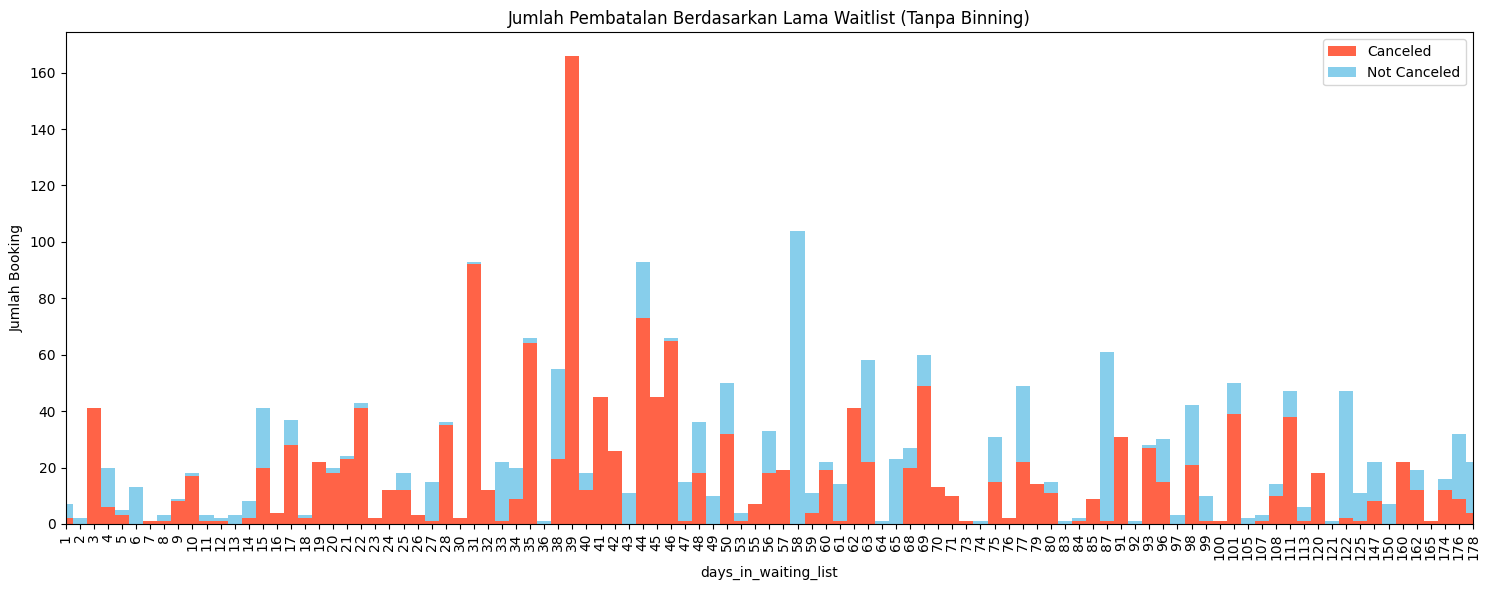

In [16]:
# Hitung jumlah cancel dan tidak cancel untuk setiap nilai waiting_list
waitlist_cancel_counts = waitlist.groupby(['days_in_waiting_list', 'is_canceled']).size().unstack().fillna(0)
waitlist_cancel_counts.columns = ['Not Canceled', 'Canceled']

# Plot bar chart
waitlist_cancel_counts[['Canceled', 'Not Canceled']].plot(
    kind='bar',
    stacked=True,
    figsize=(15, 6),
    color=['tomato', 'skyblue'],
    width=1
)

plt.title('Jumlah Pembatalan Berdasarkan Lama Waitlist (Tanpa Binning)')
plt.xlabel('days_in_waiting_list')
plt.ylabel('Jumlah Booking')
plt.xlim(0, 100)  # Fokus ke 0–100 hari
plt.tight_layout()
plt.show()

In [17]:
waitlist_cancel_counts['cancelation_rate']= waitlist_cancel_counts['Canceled'] * 100 /(waitlist_cancel_counts['Not Canceled'] + waitlist_cancel_counts['Canceled'])

In [18]:
waitlist_cancel_counts.sort_values('Canceled', ascending=False).head(20)

,Not Canceled,Canceled,cancelation_rate
days_in_waiting_list,,,
39,0.0,166.0,100.000000
31,1.0,92.0,98.924731
44,20.0,73.0,78.494624
46,1.0,65.0,98.484848
35,2.0,64.0,96.969697
69,11.0,49.0,81.666667
45,0.0,45.0,100.000000
41,0.0,45.0,100.000000
3,0.0,41.0,100.000000


In [19]:
prev_cancel = booking_df[booking_df['previous_cancellations']>0]
prev_cancel.is_canceled.value_counts()

,count
is_canceled,
1,4128
0,385


In [20]:
bookchanges_cancel_counts = booking_df.groupby(['booking_changes', 'is_canceled']).size().unstack().fillna(0)
bookchanges_cancel_counts.columns = ['Not Canceled', 'Canceled']

In [21]:
bookchanges_cancel_counts

,Not Canceled,Canceled
booking_changes,,
0,42073.0,28800.0
1,7676.0,1287.0
2,2129.0,523.0
3,547.0,92.0
4,217.0,43.0
5,76.0,14.0
6,27.0,12.0
7,22.0,1.0
8,6.0,4.0


In [22]:
bookchanges = booking_df[booking_df['booking_changes']>0].copy()
bookchanges.is_canceled.value_counts()

,count
is_canceled,
0,10722
1,1978


In [23]:
request_cancel_counts = booking_df.groupby(['total_of_special_requests', 'is_canceled']).size().unstack().fillna(0)
request_cancel_counts.columns = ['Not Canceled', 'Canceled']

In [24]:
request_cancel_counts

,Not Canceled,Canceled
total_of_special_requests,,
0,25819,23369
1,18108,5106
2,7153,1967
3,1477,307
4,208,28
5,30,1


In [25]:
request = booking_df[booking_df['total_of_special_requests']>0].copy()
request.is_canceled.value_counts()

,count
is_canceled,
0,26976
1,7409


## Feature Engineering

In [26]:
booking_df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CHN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


### type of customer + deposit status

In [27]:
booking_df['customer_deposit']= booking_df['customer_type']+'_'+booking_df['deposit_type']

In [28]:
booking_df['market_customer']= booking_df['market_segment']+'_'+booking_df['customer_type']

### change country into continent and subregion

In [29]:
manual_override = {
    'ATA': 'Antarctica',
    'UMI': 'North America',
    'TLS': 'Asia',
}

# Function to map ISO3 to continent
def map_country_to_continent(iso3_code):
    try:
        if iso3_code in manual_override:
            return manual_override[iso3_code]
        # Convert alpha-3 to alpha-2
        alpha2 = pc.country_alpha3_to_country_alpha2(iso3_code)
        # Convert alpha-2 to continent code
        continent_code = pc.country_alpha2_to_continent_code(alpha2)
        # Map code to readable name
        return {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }.get(continent_code, 'other')
    except:
        return 'other'

# Apply to DataFrame
booking_df['continent'] = booking_df['country'].apply(map_country_to_continent)
booking_df


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,customer_deposit,market_customer,continent
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,Transient-Party_No Deposit,Offline TA/TO_Transient-Party,Europe
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0,Transient_No Deposit,Online TA_Transient,Europe
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0,Transient_No Deposit,Online TA_Transient,Europe
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1,Transient_No Deposit,Online TA_Transient,Europe
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0,Transient_No Deposit,Online TA_Transient,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1,Contract_No Deposit,Online TA_Contract,Europe
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0,Transient_No Deposit,Online TA_Transient,Europe
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0,Transient_No Deposit,Online TA_Transient,Europe
83571,CHN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,Transient-Party_No Deposit,Offline TA/TO_Transient-Party,Asia


In [30]:
booking_df.groupby('continent').agg({
    'is_canceled': 'count'
})

,is_canceled
continent,
Africa,767
Antarctica,1
Asia,3117
Europe,75499
North America,1594
Oceania,353
South America,1891
other,351


In [31]:
unk_country_code = booking_df[booking_df["continent"]=='Unknown']


In [32]:
unk_country_code

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,customer_deposit,market_customer,continent


In [33]:
unk_country_code.is_canceled.value_counts()

,count
is_canceled,


In [34]:
import country_converter as coco


# Create a converter instance
cc = coco.CountryConverter()

booking_df['un_subregion'] = cc.convert(
    names=booking_df['country'],
    src='ISO3',              # source format
    to='unregion'         # target format
)

# Optional: handle unmapped or missing values
booking_df['un_subregion'] = booking_df['un_subregion'].fillna('Unknown')

In [35]:
# Calculate cancellation rate per country
cancel_df = booking_df[booking_df['is_canceled']==1].copy()
country_cancellation_rate = booking_df.groupby('country')['is_canceled'].mean().sort_values(ascending=False)

# Select the top N countries with highest cancellation rates
top_n_countries = country_cancellation_rate.head(15).index.tolist()

# Create a new binary feature 'is_top_cancel_country'
booking_df['is_top_cancel_country'] = booking_df['country'].apply(lambda x: 'yes' if x in top_n_countries else 'no')

booking_df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,customer_deposit,market_customer,continent,un_subregion,is_top_cancel_country
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,Transient-Party_No Deposit,Offline TA/TO_Transient-Party,Europe,Northern Europe,no
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0,Transient_No Deposit,Online TA_Transient,Europe,Western Europe,no
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0,Transient_No Deposit,Online TA_Transient,Europe,Southern Europe,no
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1,Transient_No Deposit,Online TA_Transient,Europe,Western Europe,no
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0,Transient_No Deposit,Online TA_Transient,Europe,Southern Europe,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1,Contract_No Deposit,Online TA_Contract,Europe,Southern Europe,no
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0,Transient_No Deposit,Online TA_Transient,Europe,Western Europe,no
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0,Transient_No Deposit,Online TA_Transient,Europe,Southern Europe,no
83571,CHN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,Transient-Party_No Deposit,Offline TA/TO_Transient-Party,Asia,Eastern Asia,no


In [36]:
country_cancellation_rate.head(15)

,is_canceled
country,
BHR,1.000000
BEN,1.000000
NIC,1.000000
MYT,1.000000
KHM,1.000000
MAC,1.000000
UMI,1.000000
VGB,1.000000
ZMB,1.000000


### binning days_in_waiting into yes/no and rule based(1month,2month, etc)

In [37]:
def bin_waitlist(days):
    if days == 0:
        return 'No waiting'
    else:
        return 'waiting list'

In [38]:
booking_df['waitlist_bin'] = booking_df['days_in_waiting_list'].apply(bin_waitlist)

### binning previous cancelation

In [39]:
def bin_prev_cancelation(number):
    if number == 0:
        return 'No previous cancelation'
    else:
        return 'previously canceled'

In [40]:
booking_df['prev_cancelation_bin'] = booking_df['previous_cancellations'].apply(bin_prev_cancelation)

### booking changes binning

In [41]:
def bin_booking_changes(changes):
    if changes == 0:
        return 'No booking changes'
    else:
        return 'changed booking'

In [42]:
booking_df['booking_changes_bin'] = booking_df['booking_changes'].apply(bin_booking_changes)

### binning request

In [43]:
def bin_request(request):
    if request == 0:
        return 'No request'
    else:
        return 'special request'

In [44]:
booking_df['request_bin'] = booking_df['total_of_special_requests'].apply(bin_request)

### binning car park

In [45]:
def bin_car_park(space):
    if space == 0:
        return 'No parking'
    else:
        return 'need parking'

In [46]:
booking_df['parking_bin'] = booking_df['required_car_parking_spaces'].apply(bin_car_park)

## Modeling

In [47]:
booking_df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,...,customer_deposit,market_customer,continent,un_subregion,is_top_cancel_country,waitlist_bin,prev_cancelation_bin,booking_changes_bin,request_bin,parking_bin
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,...,Transient-Party_No Deposit,Offline TA/TO_Transient-Party,Europe,Northern Europe,no,No waiting,No previous cancelation,No booking changes,No request,No parking
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,...,Transient_No Deposit,Online TA_Transient,Europe,Western Europe,no,No waiting,No previous cancelation,No booking changes,special request,No parking
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,...,Transient_No Deposit,Online TA_Transient,Europe,Southern Europe,no,No waiting,No previous cancelation,changed booking,special request,No parking
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,...,Transient_No Deposit,Online TA_Transient,Europe,Western Europe,no,No waiting,No previous cancelation,No booking changes,special request,No parking
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,...,Transient_No Deposit,Online TA_Transient,Europe,Southern Europe,no,No waiting,No previous cancelation,changed booking,special request,No parking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,...,Contract_No Deposit,Online TA_Contract,Europe,Southern Europe,no,No waiting,No previous cancelation,No booking changes,special request,No parking
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,...,Transient_No Deposit,Online TA_Transient,Europe,Western Europe,no,No waiting,No previous cancelation,No booking changes,special request,No parking
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,...,Transient_No Deposit,Online TA_Transient,Europe,Southern Europe,no,No waiting,No previous cancelation,changed booking,special request,No parking
83571,CHN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,...,Transient-Party_No Deposit,Offline TA/TO_Transient-Party,Asia,Eastern Asia,no,No waiting,No previous cancelation,No booking changes,No request,No parking


In [48]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# # Step 1: Split
# X = booking_df.drop(columns='is_canceled')
# y = booking_df['is_canceled']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

# # Step 2: Preprocessing
# num_cols = ['previous_cancellations', 'booking_changes', 'days_in_waiting_list',
#             'required_car_parking_spaces', 'total_of_special_requests']
# cat_cols = ['country', 'market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']

# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# cat_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
#     ('encoder', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer([
#     ('num', num_pipeline, num_cols),
#     ('cat', cat_pipeline, cat_cols)
# ])

# # Step 3: Full pipeline with model
# full_pipeline = Pipeline([
#     ('preprocessing', preprocessor),
#     ('clf', RandomForestClassifier(random_state=42))
# ])

# # Step 4: GridSearchCV with cross-validation
# param_grid = {
#     'clf__n_estimators': [50, 100],
#     'clf__max_depth': [25, 10,]
# }

# grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)

# # Step 5: Fit on training set
# grid_search.fit(X_train, y_train)

# # Step 6: Evaluate on test set
# y_pred = grid_search.predict(X_test)
# print("Best parameters:", grid_search.best_params_)
# print(classification_report(y_test, y_pred))

# # Step 7: Feature importance extraction
# # Get preprocessor and classifier
# best_pipeline = grid_search.best_estimator_
# preprocessor = best_pipeline.named_steps['preprocessing']
# model = best_pipeline.named_steps['clf']

# # Get numeric and categorical feature names
# num_features = num_cols
# cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
# cat_features = cat_encoder.get_feature_names_out(cat_cols)

# # Combine all feature names
# feature_names = list(num_features) + list(cat_features)

# # Get feature importances
# importances = model.feature_importances_
# feature_importance_df = pd.DataFrame({
#     'feature': feature_names,
#     'importance': importances
# }).sort_values(by='importance', ascending=False)

# # Show top features
# print("\nTop 10 Important Features:")
# print(feature_importance_df.head(10))

# # Step 8: Plot top features
# plt.figure(figsize=(10, 6))
# sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
# plt.title('Top 15 Feature Importances')
# plt.tight_layout()
# plt.show()

In [49]:
# # 1. Prepare data
# X = booking_df.drop(columns='is_canceled')
# y = booking_df['is_canceled']

# # 2. Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # 3. Preprocessing
# categorical_cols = X.select_dtypes(include='object').columns.tolist()
# numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

# preprocessor = ColumnTransformer([
#     ('num', StandardScaler(), numerical_cols),
#     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
# ])

# # 4. Define XGBoost classifier
# xgb_clf = XGBClassifier(
#     use_label_encoder=False,
#     eval_metric='logloss',
#     random_state=42,
#     scale_pos_weight=2  # helpful for class imbalance
# )

# # 5. Create pipeline
# pipeline = Pipeline([
#     ('preprocess', preprocessor),
#     ('clf', xgb_clf)
# ])

# # 6. Grid Search to tune for recall on canceled bookings
# param_grid = {
#     'clf__n_estimators': [100, 200],
#     'clf__max_depth': [3, 5, 7],
#     'clf__learning_rate': [0.1, 0.01]
# }

# grid = GridSearchCV(
#     pipeline,
#     param_grid,
#     cv=3,
#     scoring='f1',  # focus on recall
#     n_jobs=-1,
#     verbose=1
# )

# grid.fit(X_train, y_train)
# best_model = grid.best_estimator_

# # 7. Evaluate model
# y_pred = best_model.predict(X_test)
# print("Best Parameters:", grid.best_params_)
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, digits=2))

# # 8. Feature importance (optional)
# xgb_fitted = best_model.named_steps['clf']
# plt.figure(figsize=(10, 6))
# plot_importance(xgb_fitted, max_num_features=15)
# plt.title("XGBoost Feature Importance")
# plt.show()


### columns set


In [50]:
booking_df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,...,customer_deposit,market_customer,continent,un_subregion,is_top_cancel_country,waitlist_bin,prev_cancelation_bin,booking_changes_bin,request_bin,parking_bin
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,...,Transient-Party_No Deposit,Offline TA/TO_Transient-Party,Europe,Northern Europe,no,No waiting,No previous cancelation,No booking changes,No request,No parking
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,...,Transient_No Deposit,Online TA_Transient,Europe,Western Europe,no,No waiting,No previous cancelation,No booking changes,special request,No parking
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,...,Transient_No Deposit,Online TA_Transient,Europe,Southern Europe,no,No waiting,No previous cancelation,changed booking,special request,No parking
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,...,Transient_No Deposit,Online TA_Transient,Europe,Western Europe,no,No waiting,No previous cancelation,No booking changes,special request,No parking
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,...,Transient_No Deposit,Online TA_Transient,Europe,Southern Europe,no,No waiting,No previous cancelation,changed booking,special request,No parking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,...,Contract_No Deposit,Online TA_Contract,Europe,Southern Europe,no,No waiting,No previous cancelation,No booking changes,special request,No parking
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,...,Transient_No Deposit,Online TA_Transient,Europe,Western Europe,no,No waiting,No previous cancelation,No booking changes,special request,No parking
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,...,Transient_No Deposit,Online TA_Transient,Europe,Southern Europe,no,No waiting,No previous cancelation,changed booking,special request,No parking
83571,CHN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,...,Transient-Party_No Deposit,Offline TA/TO_Transient-Party,Asia,Eastern Asia,no,No waiting,No previous cancelation,No booking changes,No request,No parking


In [51]:
booking_df.columns

Index(['country', 'market_segment', 'previous_cancellations',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_canceled', 'customer_deposit',
       'market_customer', 'continent', 'un_subregion', 'is_top_cancel_country',
       'waitlist_bin', 'prev_cancelation_bin', 'booking_changes_bin',
       'request_bin', 'parking_bin'],
      dtype='object')

In [52]:
columns_1 = booking_df[['market_segment',
      'reserved_room_type', 'parking_bin','is_top_cancel_country',
       'request_bin', 'un_subregion','booking_changes','prev_cancelation_bin', 'days_in_waiting_list']]

In [53]:
columns_2 = booking_df[['country', 'market_segment', 'previous_cancellations',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests']]

In [54]:
columns_3 = booking_df[['un_subregion', 'market_segment','customer_type', 'prev_cancelation_bin',
       'booking_changes_bin', 'deposit_type', 'waitlist_bin','reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests']]

In [55]:
def safe_get_feature_names(transformer, input_cols, prefix):
    try:
        return transformer.get_feature_names_out(input_cols)
    except:
        # Fallback: Assume each input column produces one or more features, use generic names
        return [f"{prefix}__{col}_{i}" if i > 0 else f"{prefix}__{col}"
                for col in input_cols for i in range(1)]  # adjust range if multi-output

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:31:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 11, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 2.058352285913205}
=== Train Classification Report (threshold = 0.5) ===
              precision    recall  f1-score   support

           0       0.89      0.73      0.80     36956
           1       0.64      0.85      0.73     21545

    accuracy                           0.77     58501
   macro avg       0.77      0.79      0.76     58501
weighted avg       0.80      0.77      0.77     58501

=== Test Classification Report (threshold = 0.5) ===
              precision    recall  f1-score   support

           0       0.88      0.72      0.79     15839
           1       0.64      0.83      0.72      9233

    accuracy                           0.76     25072
   macro avg       0.76      0.78      0.76     25072
weighted avg       0.79      0.76      0.77     25072



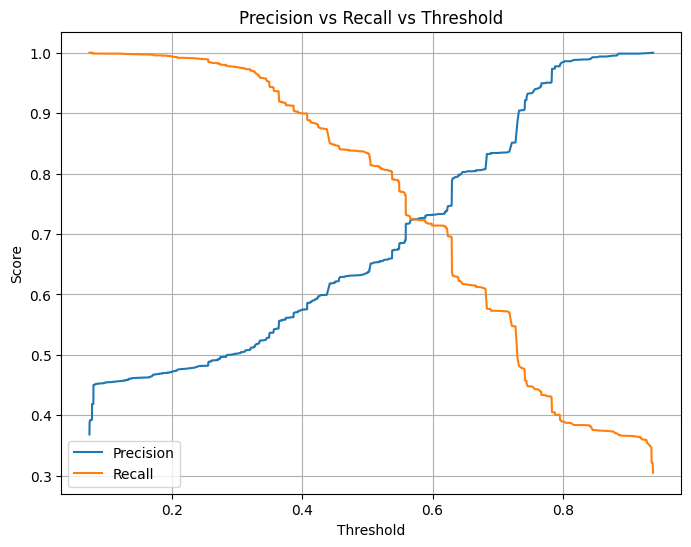

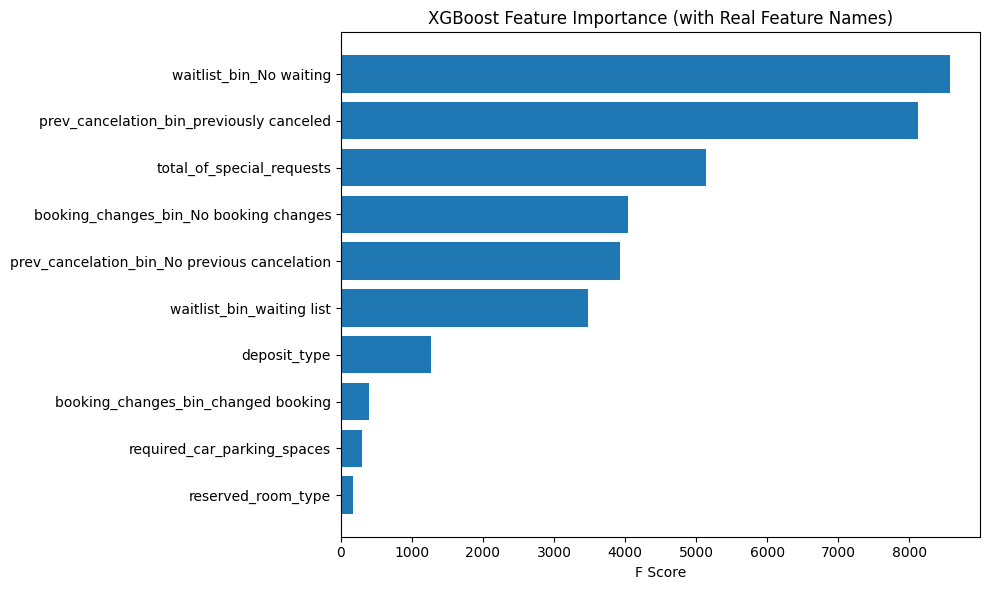

In [62]:
# 1. Prepare data
X = columns_3
y = booking_df['is_canceled']

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 3. Preprocessing
# --- Feature lists ---
numerical_cols = [
    'total_of_special_requests',
    'required_car_parking_spaces'
]

ordinal_cols = [
    'market_segment',
    'deposit_type',
    'customer_type',
    'reserved_room_type',
    'un_subregion'
]
ohe_cols = [
    'booking_changes_bin',
    'prev_cancelation_bin',
    'waitlist_bin']

# --- Preprocessing Pipelines ---
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])
ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('encoder', OneHotEncoder())
])
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


# --- Combine all in ColumnTransformer ---
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_cols),
    ('ord', ordinal_pipeline, ordinal_cols),
    ('ohe', ohe_pipeline,ohe_cols)
], remainder='passthrough')  # passthrough keeps already encoded binary columns

# 4. Define XGBoost classifier
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 5. Create pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', xgb_clf)
])

# Compute class imbalance ratio
neg = sum(y_train == 0)
pos = sum(y_train == 1)
ratio = neg / pos

# 6. Grid Search to tune for recall on canceled bookings
param_grid = {
    'clf__n_estimators': [200],
    'clf__max_depth': [11],
    'clf__learning_rate': [0.1, 0.01],
    'clf__scale_pos_weight': [ratio, 1.2 * ratio]
}

scoring = {
    'recall': 'recall',
    'f1': 'f1',
    'precision': 'precision'
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring=scoring,
    refit='recall',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# === 7. Evaluation with custom threshold ===
threshold = 0.5  # adjust as needed

# Predict probabilities
y_train_probs = best_model.predict_proba(X_train)[:, 1]
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Apply threshold
y_train_pred_thresh = (y_train_probs >= threshold).astype(int)
y_test_pred_thresh = (y_test_probs >= threshold).astype(int)

# Print evaluation
print("Best Parameters:", grid.best_params_)
print(f"=== Train Classification Report (threshold = {threshold}) ===")
print(classification_report(y_train, y_train_pred_thresh, digits=2))
print(f"=== Test Classification Report (threshold = {threshold}) ===")
print(classification_report(y_test, y_test_pred_thresh, digits=2))

# === 8. Plot precision-recall vs threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_probs)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

# === 9. Feature importance (with actual feature names)
xgb_fitted = best_model.named_steps['clf']
fitted_preprocessor = best_model.named_steps['preprocess']

# Get transformed feature names
num_features = safe_get_feature_names(
    fitted_preprocessor.named_transformers_['num'], numerical_cols, "num"
)
ohe_features = safe_get_feature_names(
    fitted_preprocessor.named_transformers_['ohe'], ohe_cols, "ohe"
)
ord_features = safe_get_feature_names(
    fitted_preprocessor.named_transformers_['ord'], ordinal_cols, "ord"
)

# Combine all
all_feature_names = np.concatenate([num_features, ohe_features, ord_features])

# Get importance scores
importance_dict = xgb_fitted.get_booster().get_score(importance_type='weight')

# Map f0, f1, ... to actual names
mapped_importance = {
    all_feature_names[int(k[1:])]: v for k, v in importance_dict.items()
}

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': list(mapped_importance.keys()),
    'FScore': list(mapped_importance.values())
}).sort_values(by='FScore', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['FScore'][:15][::-1])
plt.xlabel('F Score')
plt.title('XGBoost Feature Importance (with Real Feature Names)')
plt.tight_layout()
plt.show()

In [ ]:
X_transformed = fitted_preprocessor.transform(X_train)
print("Transformed shape:", X_transformed.shape)
print("Total feature names:", len(all_feature_names))

In [61]:
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['total_of_special_requests',
                                                   'required_car_parking_spaces']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_un...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [63]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_pred_thresh))

[[11420  4419]
 [ 1531  7702]]


In [66]:
import pickle

# Save the trained model pipeline
with open("cancellation_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [67]:
import os

# List files in the current directory
os.listdir()

['.config', 'drive', 'cancellation_model.pkl', 'sample_data']

In [68]:
from google.colab import files
files.download("cancellation_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>